In [1]:
from IPython.display import HTML
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report
import splitfolders

import os
import pandas as pd
import numpy as np

from PIL import Image
import seaborn as sns
from matplotlib.image import imread

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing import image


In [2]:
data_dir = r"C:\Users\sunday\Desktop\dataset\pepper_images"

filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

In [3]:
train_df, temp_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)


In [4]:
IMAGE_SIZE = 256
CHANNELS = 3 
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='binary',  
    batch_size=32
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 1980 validated image filenames belonging to 2 classes.
Found 247 validated image filenames belonging to 2 classes.
Found 248 validated image filenames belonging to 2 classes.


In [5]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes)
class_weights = dict(enumerate(class_weights))


In [28]:
def count_labels(generator, generator_name):
    class_counts = dict(zip(generator.class_indices.keys(), 
                          np.bincount(generator.classes)))
    
    print(f"\n{generator_name} set class distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")
    return class_counts
    
train_counts = count_labels(train_generator, "Training")
val_counts = count_labels(val_generator, "Validation")
test_counts = count_labels(test_generator, "Test")




Training set class distribution:
Pepper,_bell___Bacterial_spot: 807 images
Pepper,_bell___healthy: 1173 images

Validation set class distribution:
Pepper,_bell___Bacterial_spot: 86 images
Pepper,_bell___healthy: 161 images

Test set class distribution:
Pepper,_bell___Bacterial_spot: 104 images
Pepper,_bell___healthy: 144 images


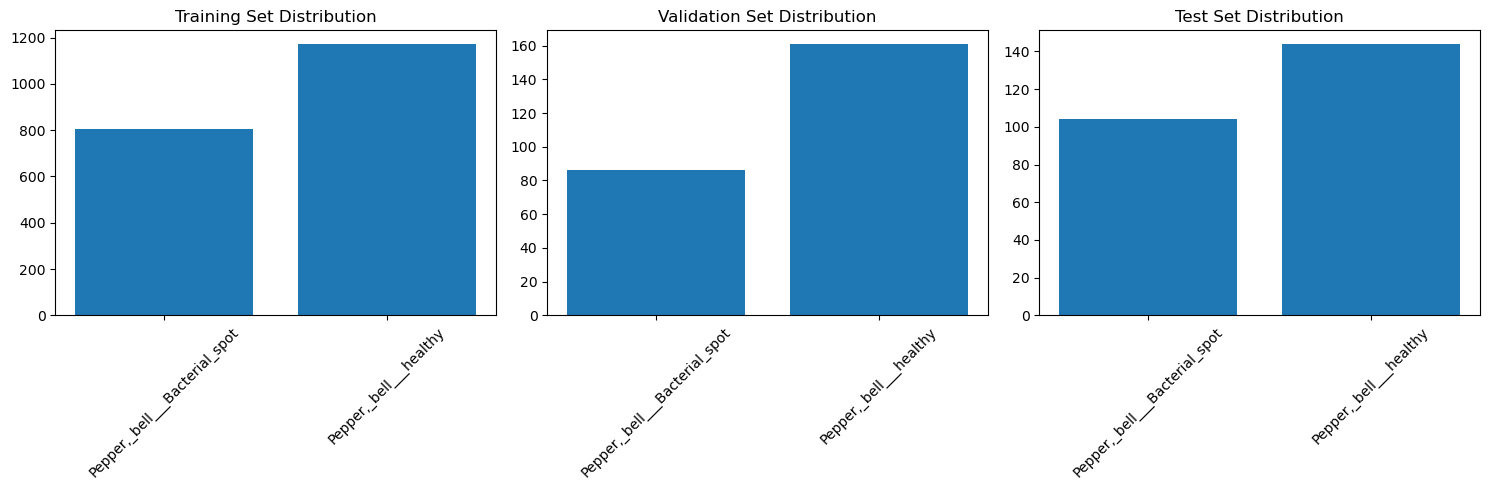

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Training Set Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(val_counts.keys(), val_counts.values())
plt.title('Validation Set Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(test_counts.keys(), test_counts.values())
plt.title('Test Set Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,761 (1.06 MB)

 Trainable params: 277,761 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)



In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
    class_weight=class_weights  
)

C:\Users\sunday\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.5587 - loss: 0.6700 - precision: 0.6478 - recall: 0.4884 - val_accuracy: 0.8340 - val_loss: 0.4402 - val_precision: 0.9839 - val_recall: 0.7578
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9181 - loss: 0.2692 - precision: 0.9280 - recall: 0.9375 - val_accuracy: 0.8907 - val_loss: 0.3353 - val_precision: 1.0000 - val_recall: 0.8323
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9530 - loss: 0.1544 - precision: 0.9652 - recall: 0.9571 - val_accuracy: 0.9676 - val_loss: 0.1233 - val_precision: 0.9693 - val_recall: 0.9814
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9783 - loss: 0.0914 - precision: 0.9831 - recall: 0.9796 - val_accuracy: 0.9717 - val_loss: 0.0948 - val_precision: 1.0000 - val_recall: 0.9565
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.9835 - loss: 0.0558 - precision: 0.9860 - recall: 0.9857 - val_accuracy: 0.9150 - val_loss: 0.3069 

In [19]:
model.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 721ms/step - accuracy: 0.9951 - loss: 0.0078 - precision: 0.9915 - recall: 1.0000


[0.011204449459910393, 0.9919354915618896, 0.9863013625144958, 1.0]

In [20]:
model.evaluate(val_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 742ms/step - accuracy: 0.9901 - loss: 0.1306 - precision: 1.0000 - recall: 0.9848


[0.05598181113600731, 0.9959514141082764, 1.0, 0.9937888383865356]

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']

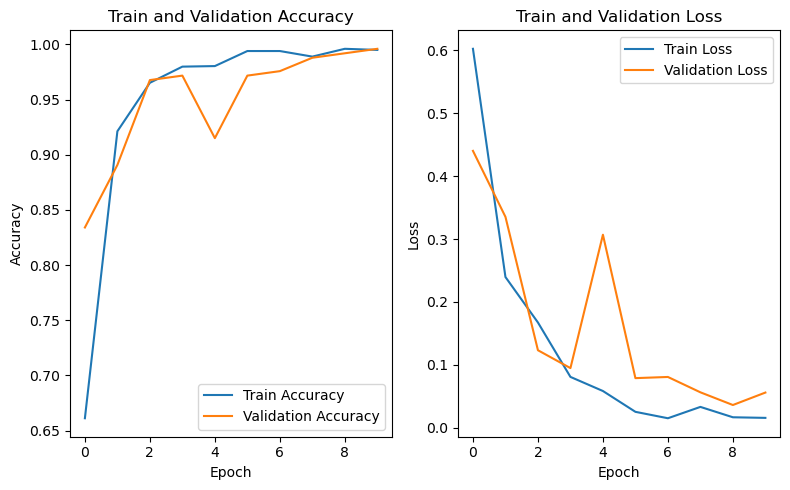

In [23]:
plt.figure(figsize=(8, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [25]:
pred_probabilities = model.predict(test_generator)
threshold = 0.5
predictions = pred_probabilities > threshold

print(classification_report(test_generator.classes, predictions, target_names=img_classes))

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step
                               precision    recall  f1-score   support

Pepper,_bell___Bacterial_spot       1.00      0.98      0.99       104
       Pepper,_bell___healthy       0.99      1.00      0.99       144

                     accuracy                           0.99       248
                    macro avg       0.99      0.99      0.99       248
                 weighted avg       0.99      0.99      0.99       248



In [26]:
# Confusion matrix
cm = confusion_matrix(test_generator.classes, predictions)
cm

array([[102,   2],
       [  0, 144]], dtype=int64)

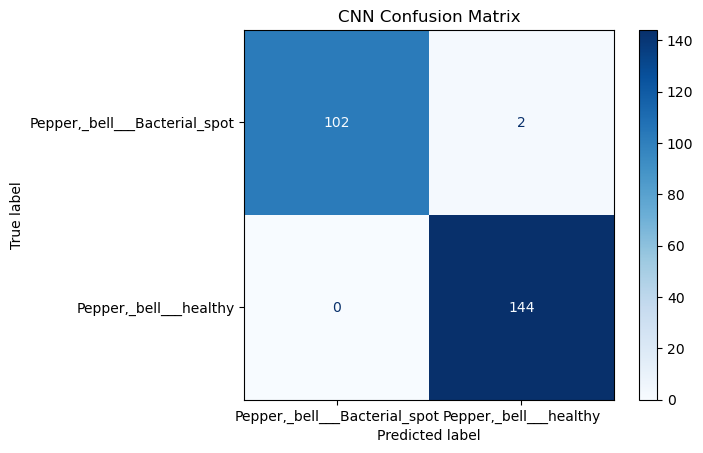

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix')
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def predict_and_show_with_confidence(generator, model, img_classes):
    
       for images_batch, label_batch in generator:
     
        first_image = images_batch[0]
        first_label = int(label_batch[0])
        
        plt.figure(figsize=(4, 4))
        plt.imshow(first_image)
        plt.axis('off')
        plt.show()
        
        prediction = model.predict(np.expand_dims(first_image, axis=0))
        predicted_class = int(prediction[0] > 0.5)  # For binary classification
        confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]
        
        print(f"Actual label: {img_classes[first_label]}")
        print(f"Predicted label: {img_classes[predicted_class]}")
        print(f"Confidence: {confidence:.2%}")
        
        break  


In [11]:
img_classes  = os.listdir(r"C:\Users\sunday\Desktop\dataset\pepper_images")
print(img_classes)

['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy']


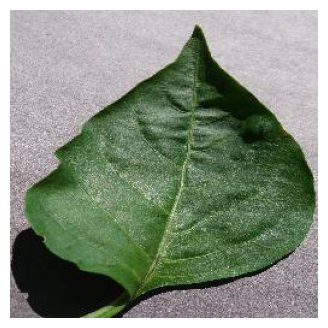

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Actual label: Pepper,_bell___healthy
Predicted label: Pepper,_bell___healthy
Confidence: 100.00%


C:\Users\sunday\AppData\Local\Temp\ipykernel_13400\2875902971.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction[0] > 0.5)  # For binary classification


In [16]:
predict_and_show_with_confidence(test_generator, model, img_classes)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math

def show_batch_predictions(generator, model, class_names, batch_size=9):
    images, true_labels = next(generator)
    
    grid_size = math.isqrt(batch_size)
    if grid_size * grid_size != batch_size:
        batch_size = grid_size * grid_size
    
    predictions = model.predict(images[:batch_size])
    plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        true_class = int(true_labels[i])
        pred_prob = predictions[i][0]
        pred_class = 1 if pred_prob >= 0.5 else 0
        confidence = pred_prob if pred_class == 1 else 1 - pred_prob
        
        text_color = 'green' if pred_class == true_class else 'red'
        
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        
        title = f"Actual: {class_names[true_class]}\n"
        title += f"Pred: {class_names[pred_class]}\n"
        title += f"Conf: {confidence:.2%}"
        
        plt.title(title, color=text_color, fontsize=10)
    
    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


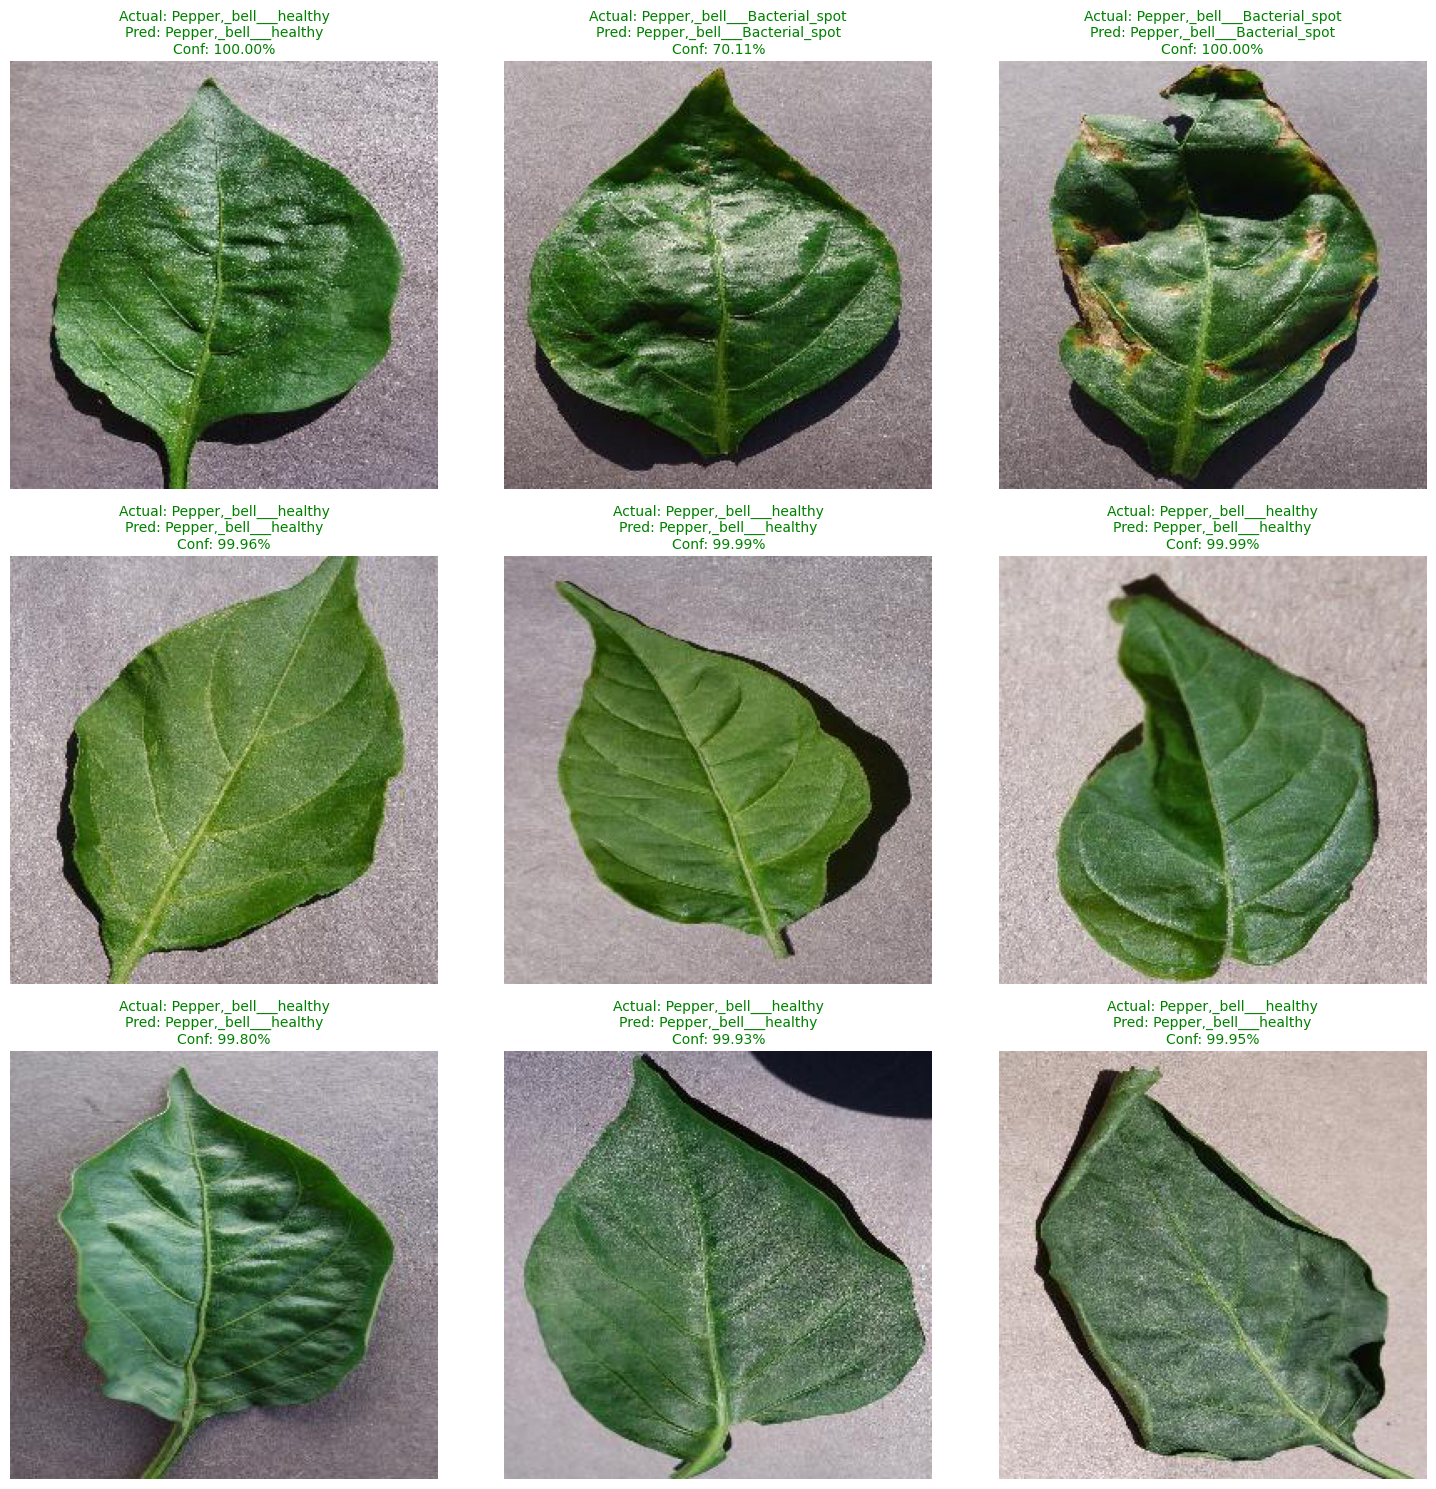

In [18]:
class_names = list(test_generator.class_indices.keys())

show_batch_predictions(test_generator, model, class_names)

In [30]:
model.save('adam.keras')